In [125]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision.io import read_image
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
sys.path.append('../')
import torch as tc
from src.dataset.dataloader import *
from models.autoencoders import Model_1

In [126]:
path = "../data/images"
dataset = CREDO_Small_Dataset(path, transform_better=True, conv=True)

In [127]:
batch = 4
loader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=5)

Let's visualize some of the data we're dealing with

1.0
1.0
1.0
1.0
1.0
1.0


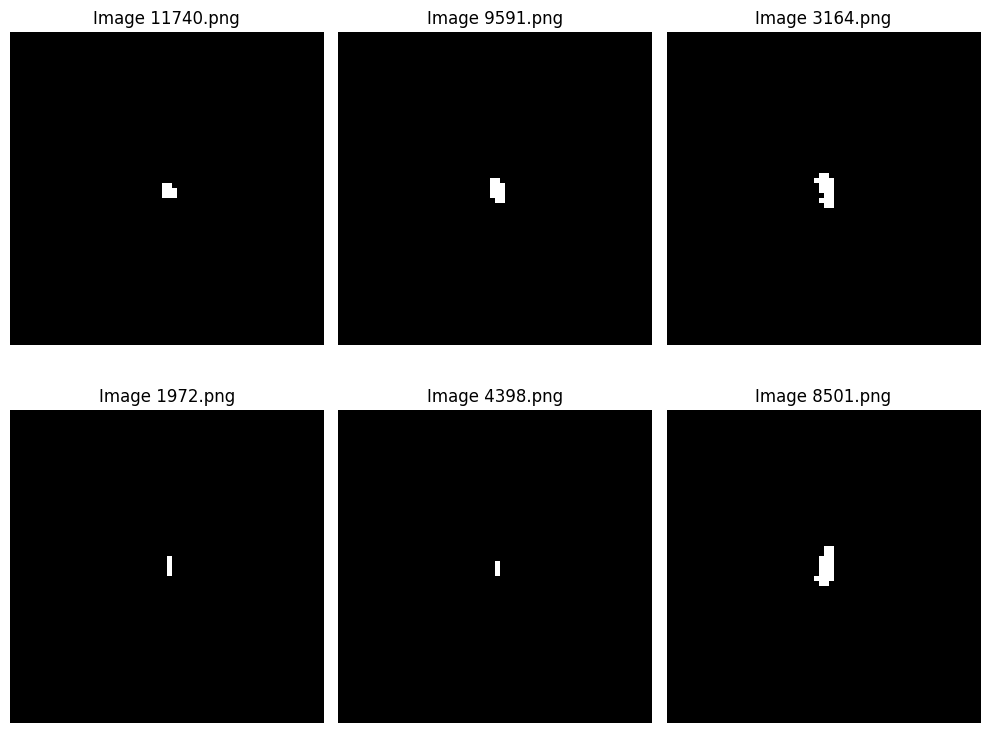

In [128]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    random_index = random.randint(0, len(loader.dataset))
    image = loader.dataset[random_index][0]
    print(image.max())
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Image {random_index}.png')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [129]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [130]:
import importlib
importlib.reload(sys.modules['models.autoencoders'])
from models.autoencoders import *

In [131]:
model_conv = Model_1()  #Model_with_Max_pool()
model_conv = Autoencoder()
model_conv.to(device)   #.double()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [132]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

Below we define some training parameters:
- Number of epochs
- Criterion
- Learning rate
- Weight decay
- Optimizer

In [133]:
#Loss function
CRITERION = nn.MSELoss() #DiceLoss() #nn.MSELoss() #nn.BCELoss()

#Hyperparameters
EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.8

# Optimizers
OPTIMIZER_CONV = optim.SGD(model_conv.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay = WEIGHT_DECAY)


## Model Training

In [134]:
conv_losses = []
conv_output = []

for epoch in range(EPOCHS):
    loss_full = 0
    for img, file in tqdm(loader):
        # img = img.reshape(-1, 1, 64, 64)
        img = img.unsqueeze(1)
        # Forward pass

        img = img.cuda()

        OPTIMIZER_CONV.zero_grad()

        outputs = model_conv(img)
 
        loss = CRITERION(outputs, img)

        # Backward pass and optimization
        loss.backward()
        OPTIMIZER_CONV.step()
        
        loss_full += loss.item()
    
    loss_full = loss_full/len(loader)
    conv_losses.append(loss_full)
    
    print(f'Epoch: {epoch + 1}, Loss: {loss_full:.7f}')
    conv_output.append((epoch, img, outputs))


100%|██████████| 3451/3451 [00:26<00:00, 128.02it/s]


Epoch: 1, Loss: 0.0796860


100%|██████████| 3451/3451 [00:26<00:00, 128.76it/s]


Epoch: 2, Loss: 0.0176124


100%|██████████| 3451/3451 [00:26<00:00, 128.24it/s]


Epoch: 3, Loss: 0.0105633


100%|██████████| 3451/3451 [00:27<00:00, 127.80it/s]


Epoch: 4, Loss: 0.0079719


100%|██████████| 3451/3451 [00:26<00:00, 128.46it/s]


Epoch: 5, Loss: 0.0066477


100%|██████████| 3451/3451 [00:26<00:00, 128.65it/s]


Epoch: 6, Loss: 0.0058515


100%|██████████| 3451/3451 [00:26<00:00, 128.30it/s]


Epoch: 7, Loss: 0.0053233


100%|██████████| 3451/3451 [00:29<00:00, 116.97it/s]


Epoch: 8, Loss: 0.0049489


100%|██████████| 3451/3451 [00:28<00:00, 119.41it/s]


Epoch: 9, Loss: 0.0046707


100%|██████████| 3451/3451 [00:29<00:00, 116.78it/s]


Epoch: 10, Loss: 0.0044563


100%|██████████| 3451/3451 [00:28<00:00, 120.72it/s]


Epoch: 11, Loss: 0.0042864


100%|██████████| 3451/3451 [00:28<00:00, 122.65it/s]


Epoch: 12, Loss: 0.0041487


100%|██████████| 3451/3451 [00:29<00:00, 118.26it/s]


Epoch: 13, Loss: 0.0040350


100%|██████████| 3451/3451 [00:28<00:00, 122.11it/s]


Epoch: 14, Loss: 0.0039396


100%|██████████| 3451/3451 [00:28<00:00, 122.53it/s]


Epoch: 15, Loss: 0.0038585


100%|██████████| 3451/3451 [00:28<00:00, 121.06it/s]


Epoch: 16, Loss: 0.0037888


100%|██████████| 3451/3451 [00:28<00:00, 119.39it/s]


Epoch: 17, Loss: 0.0037283


100%|██████████| 3451/3451 [00:28<00:00, 119.73it/s]


Epoch: 18, Loss: 0.0036754


100%|██████████| 3451/3451 [00:28<00:00, 121.15it/s]


Epoch: 19, Loss: 0.0036287


100%|██████████| 3451/3451 [00:28<00:00, 119.69it/s]


Epoch: 20, Loss: 0.0035873


100%|██████████| 3451/3451 [00:28<00:00, 120.03it/s]


Epoch: 21, Loss: 0.0035502


100%|██████████| 3451/3451 [00:28<00:00, 122.88it/s]


Epoch: 22, Loss: 0.0035169


100%|██████████| 3451/3451 [00:28<00:00, 123.14it/s]


Epoch: 23, Loss: 0.0034868


100%|██████████| 3451/3451 [00:28<00:00, 120.61it/s]


Epoch: 24, Loss: 0.0034595


100%|██████████| 3451/3451 [00:28<00:00, 119.97it/s]


Epoch: 25, Loss: 0.0034347


100%|██████████| 3451/3451 [00:28<00:00, 120.93it/s]


Epoch: 26, Loss: 0.0034120


 14%|█▍        | 488/3451 [00:18<01:51, 26.60it/s] 


KeyboardInterrupt: 

In [ ]:
#Model_with_max_pool + RELU       Lr = 1e-4, batch = 256, epoch =15, Loss: 0.0003672 (nie uczy sie)
#Model_with_max_pool + Sigmoid    Lr = 1e-3, batch = 256, epoch =10, Loss:? 

5

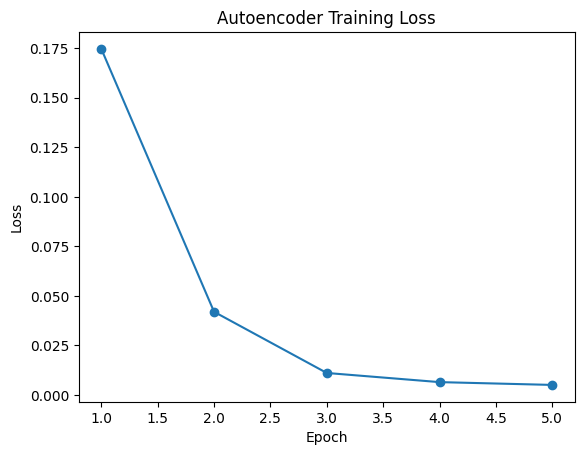

In [ ]:
plt.plot(range(1, EPOCHS+1), conv_losses, marker='o')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

(1, 1, 64, 64)
1.0
0.0021937978453934193


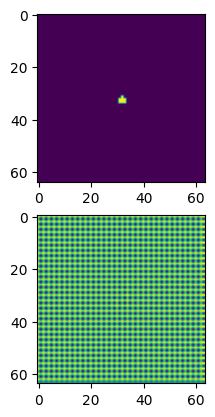

In [137]:
image = dataset.__getitem__(1000)[0]



image = image.reshape(1, 1, 64, 64)
load = iter(tc.utils.data.DataLoader(image))
print(image.shape)
print(image.max())
img = next(load).to(device)



plt.subplot(2, 1, 1)
plt.imshow(img.detach().cpu().reshape(64, 64))

plt.subplot(2, 1, 2)
output = model_conv(img)
print(CRITERION(output, img).item())
plt.imshow(output.detach().cpu().reshape(64, 64))

In [ ]:
print(np.round(conv_losses, 8))

[0.17466134 0.04195163 0.01106705 0.00645007 0.00503557]


In [ ]:
reconstruction_errors = []

error_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=3)


# Reconstructed data
for image, file in error_loader:
    image = image.unsqueeze(1)
    image = image.cuda()
    recon = model_conv(image)

    loss = CRITERION(recon, image)
    
    reconstruction_errors.append(loss.item())




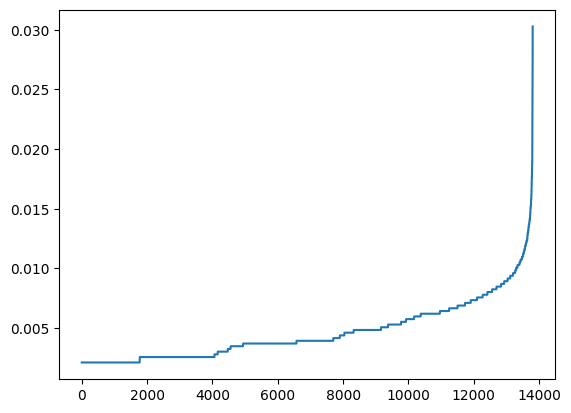

In [ ]:
indexes = [x for _, x in sorted(zip(reconstruction_errors ,range(0, len(error_loader))))]
mse_list_s = sorted(reconstruction_errors)
plt.plot(mse_list_s)

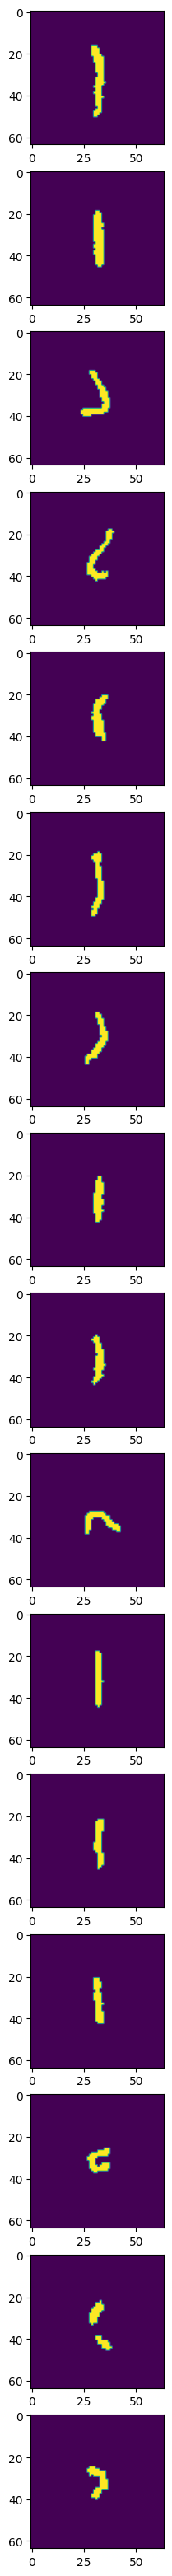

In [ ]:

x = -1

size = 400000

plt.figure(figsize=(10, 40))

for index, i in enumerate(range(x, x-16, -1)):
    plt.subplot(16, 3, 3*index+1)
    plt.imshow(dataset[indexes[i]][0])

    